<a href="https://colab.research.google.com/github/JoshuaOgbe/JoshuaOgbe/blob/main/financial_review0328_dense_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis of Financial News

- In the following, we will explore data modeling to predict numbers of positive, neutral and negative sentiments of the reviews.
- For each review, which forms the independent variable, one of the three sentiments was assigned. 

### Importing necessary libraries 

In [ ]:
import pandas as pd
import numpy as np
import nltk
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
import re, string, unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import optimizers

In [ ]:
optimizers.RMSprop()

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Input
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

### Load the dataset

In [ ]:
data = pd.read_csv('all-data.csv', names=['sentiment','text'], encoding='latin-1',header=None) 

In [ ]:
data.head(20)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


### Exploring the data 

In [ ]:
# there are total 4846 rows 
data.describe() 

,sentiment,text
count,4846,4846
unique,3,4838
top,neutral,Ahlstrom 's share is quoted on the NASDAQ OMX ...
freq,2879,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   text       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [ ]:
# Distribution of values in the target variable.
data['sentiment'].value_counts()

neutral     2879
positive    1363
negative     604
Name: sentiment, dtype: int64

<AxesSubplot:>

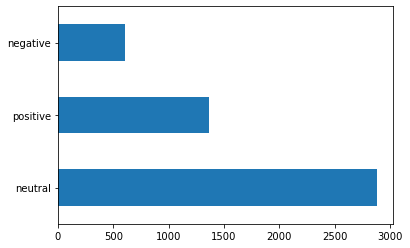

In [ ]:
# We notice that the classification is not balanced 
CountStatus = pd.value_counts(data['sentiment'].values, sort=True)
CountStatus.plot.barh()

#### Dropping the duplicated rows 

In [ ]:
# Identifying the duplicated rows and eliminating them 
len(data[data.duplicated()])

6

In [ ]:
data=data.drop_duplicates()

In [ ]:
print(data.shape)

(4840, 2)


## Preprocessing 

- Import the reqruied NLTK toolkit

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raehy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raehy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Text Normalization 

In [ ]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#### Cleanining the texts 

In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
#Removing the square brakets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [ ]:
#Removing special characters
def remove_special_characters(text, remove_digits=True):
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text) 
  return text

In [ ]:
# substituting multiple spaces with single space 
def sub_multi_space (text):
    text= re.sub(r'\s+', ' ', text, flags=re.I)
    return text

In [ ]:
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text, remove_digits=True)
    text = sub_multi_space (text) 
    return text

In [ ]:
#Apply function on review column
data['text']=data['text'].apply(denoise_text)

### Labeling the target variable 

In [ ]:
# Labeling the target variable classes in numeric type
label_mapping = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }
    


In [ ]:
data['sentiment']=data['sentiment'].replace(label_mapping) 

In [ ]:
data.head()

,sentiment,text
0,1,According to Gran the company has no plans to ...
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company s updated strategy fo...


### Removing Stopwords

In [ ]:
 nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raehy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)


#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
data['text']=data['text'].apply(remove_stopwords)

{'which', 'that', "shan't", "weren't", 'if', 'just', 'should', "wasn't", 'can', 'i', 'what', 'above', 'mightn', 'so', 'mustn', "shouldn't", "hasn't", 'weren', 'will', 'isn', 'up', 'wouldn', "needn't", 'because', "aren't", 'to', 'have', 'yourselves', 'hers', 'own', 'were', "couldn't", 'myself', 'but', 'her', 'his', "she's", 'only', 'ourselves', 'ain', 'and', 'against', 'wasn', 'are', 'through', 'has', 'be', 'themselves', 'itself', 'where', 'he', "didn't", "wouldn't", 'below', 'these', 'too', 'between', "won't", 'during', 'shan', 'once', 'then', 'very', "should've", 'yours', 'o', 'of', 'not', 'into', 'shouldn', 'don', 'himself', 'when', 'him', 'after', 'your', 'them', 've', "it's", 'each', "you've", 'over', 'how', 'than', 'whom', 'do', 'herself', 'won', "mustn't", 'while', "doesn't", 'did', 'my', 'd', 'those', 'a', 'in', 'with', "that'll", 'ma', 'having', 'had', 'off', 'its', 'aren', 'why', 'she', 'about', "you're", 'didn', 'this', 'll', 'doesn', 'hadn', 'an', 'more', 'ours', 'their', 't

### Lemmatization

- Lemmatization is a linguistic term that means grouping together words with the same root or lemma but with different inflections or derivatives of meaning so they can be analyzed as one item. The aim is to take away inflectional suffixes and prefixes to bring out the word’s dictionary form.

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemma_text(text):
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text
data['text']=data['text'].apply(lambda x: lemma_text(x))

In [ ]:
data['text'].head()

0    According Gran company plan move production Ru...
1    Technopolis plan develop stage area le 100000 ...
2    international electronic industry company Elco...
3    new production plant company would increase ca...
4    According company update strategy year 2009201...
Name: text, dtype: object

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
cores = multiprocessing.cpu_count()

In [ ]:
w2v_model = Word2Vec(data['text'],
                     min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

In [ ]:
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 65 - Embedding Dim: 300


In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += w2v_model[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(data['text']), 300)) 
for i in range(len(data['text'])):
    wordvec_arrays[i,:] = word_vector(data['text'][i], 300)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

C:\Users\raehy\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


KeyError: 1099

### Normalized train ['text'] 

In [ ]:
#normalized train text
norm_train_text=data.text[:4845]
norm_train_text[1]

'Technopolis plan develop stage area le 100000 square meter order host company work computer technology telecommunication statement say'

### Bags of Words 

- Text data must be converted to a real-valued numeric vector. The two common approaches are Count Occurence and TF-IDF

In [ ]:
#Count vectorizer for bag of words
cv=CountVectorizer()
#transformed train reviews
X_train_counts = cv.fit_transform(norm_train_text)


In [ ]:
print('BOW_cv_train:', X_train_counts.shape)


BOW_cv_train: (4840, 9698)


In [ ]:
#Tfidf Transformer
tf=TfidfTransformer()
#transformed train reviews
X_train_tfidf =tf.fit_transform(X_train_counts)


In [ ]:
print('Tfidf_train:',X_train_tfidf.shape)

Tfidf_train: (4840, 9698)


### Data Modelling 

#### Logistics Regression 
#### Random Forest Classifier

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import pickle



In [ ]:

X_train, X_test, Y_train, Y_test= train_test_split(X_train_tfidf,data['sentiment'].values, test_size=0.3)

In [ ]:
pipeline = Pipeline ([('vect', tf),('chi', SelectKBest(chi2, k=1200)), ('clf',LogisticRegression())])

In [ ]:
# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train_tfidf, data['sentiment'].values)
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)
ytest = np.array(Y_test)

In [ ]:
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.41      0.57       166
           1       0.74      0.97      0.84       872
           2       0.85      0.49      0.62       414

    accuracy                           0.77      1452
   macro avg       0.84      0.62      0.68      1452
weighted avg       0.79      0.77      0.75      1452

[[ 68  85  13]
 [  2 846  24]
 [  2 210 202]]


- 78% of accuracy is not considered highly effective. Therefore, I will try with Random Forest Classifier Model. 

In [ ]:
pipeline = Pipeline ([('vect', tf),('chi', SelectKBest(chi2, k=1200)), ('clf',RandomForestClassifier())])

In [ ]:
# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train_tfidf, data['sentiment'].values)
with open('RandomForest.pickle', 'wb') as g:
    pickle.dump(model, g)
ytest = np.array(Y_test)

In [ ]:
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       166
           1       0.99      1.00      0.99       872
           2       1.00      0.97      0.98       414

    accuracy                           0.99      1452
   macro avg       0.99      0.99      0.99      1452
weighted avg       0.99      0.99      0.99      1452

[[165   1   0]
 [  0 871   1]
 [  0  12 402]]


- The acccuracy rate of 99% implies that the model may overfit the training dataset. In hope of closing the gap between under nad overfitting, let's give a shot to Artificial Neural Network 

### Neural Network 

#### Split the data to train and test sets 

In [ ]:
X = X_train_tfidf.toarray()
y = (np.array(data['sentiment'].values))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Make sure the dataset sizes of train and test are equal

In [ ]:
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (3872, 9698), 
Test dataset shape: (968, 9698)


In [ ]:
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(Y_train.shape, Y_test.shape))

Train dataset shape: (3872,), 
Test dataset shape: (968,)


#### Build the model 

In [ ]:
# First, let's create a function that returns the appropriate number of units and the activation for the last layer.

def get_last_layer_units_and_activation(num_classes):
    if num_classes == 3:
        activation = 'softmax'
        units = 1
    else:
        activation = 'relu'
        units = num_classes
    return units, activation

In [ ]:
DROPOUT_RATE = 0.2
UNITS = 512
NUM_CLASSES = 3
LAYERS = 3
input_shape = X_train_tfidf.shape[1:]


op_units, op_activation = get_last_layer_units_and_activation(NUM_CLASSES)

model = Sequential()

# Applies Dropout to the input
model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
for _ in range(LAYERS-1):
    model.add(Dense(units=UNITS, activation='relu'))
    model.add(Dropout(rate=DROPOUT_RATE))
    
model.add(Dense(units=op_units, activation=op_activation))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 9698)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4965888   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 5,229,057
Trainable params: 5,229,057
Non-trainable params: 0
______________________________________________

In [ ]:
LEARNING_RATE = 1e-3

# Compile model with parameters
if NUM_CLASSES == 3:
    loss = 'categorical_crossentropy'
else:
    loss = 'sparse_categorical_crossentropy'
optimizer = tf.optimizers.Adam(Lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

AttributeError: 'TfidfTransformer' object has no attribute 'optimizers'

In [ ]:
EPOCHS = 100
BATCH_SIZE = 128

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

In [ ]:
history = model.fit(X_train, Y_train, epochs=EPOCHS, validation_data=(X_test, Y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

### Evaludate the Model + Plotting Accuracy and Loss

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))


In [ ]:
# Plot accuracy
plt.plot(epochs,acc,label='Training_acc', color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title('Training and Validation Accuracy')

In [ ]:
#Plot loss
plt.plot(epochs,loss,label='Training_loss', color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title('Training and Validaiton loss')